## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [2]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [3]:
# Download MNIST
transform = transforms.Compose([
    # see what different tranformation you can do , one is converting the image into tensor
    # We use ToTensor to convert PIL images to PyTorch tensors.
    # Normalize is standard for MNIST ((mean,), (std,)) to help training stability.
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
   # fill this
   root='./data',
   train=True,
   download=True,
   transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    # fill this
    root='./data',
    train=False,
    download=True,
    transform=transform
)
# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.97MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]

✅ MNIST loaded: 60000 train, 10000 test images


In [4]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
    #fill this
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}

#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples
    """
    # Lists to store the final data tuples (image, label)
    train_data = []
    support_data = []
    query_data = []

    # Iterate through each class in the current task (e.g., for Task A: 0, then 1)
    for class_idx, class_label in enumerate(task_classes):
        #  Find all indices in the original dataset that correspond to this digit
        all_indices = np.where(dataset.targets == class_label)[0]

        #  Shuffle indices to ensure random selection
        np.random.shuffle(all_indices)

        # Select the specific number of examples needed
        # We need total: n_train + n_support + n_query
        start = 0
        end_train = n_train
        end_support = n_train + n_support
        end_query = n_train + n_support + n_query

        # Slice the indices
        train_indices = all_indices[start:end_train]
        support_indices = all_indices[end_train:end_support]
        query_indices = all_indices[end_support:end_query]

        # Extract data and REMAP LABELS
        # We remap labels to 0 or 1 based on their position in task_classes.
        # Example Task E [8, 9]: Label 8 becomes 0, Label 9 becomes 1.

        for idx in train_indices:
            img, _ = dataset[idx]
            train_data.append((img, class_idx))

        for idx in support_indices:
            img, _ = dataset[idx]
            support_data.append((img, class_idx))

        for idx in query_indices:
            img, _ = dataset[idx]
            query_data.append((img, class_idx))

    # Shuffle the final datasets so classes are mixed
    random.shuffle(train_data)
    random.shuffle(support_data)
    random.shuffle(query_data)

    return train_data, support_data, query_data
# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [5]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [6]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)
# --- Part A (continued): Build Your Model ---
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        # 1. CONVOLUTIONAL LAYERS
        # Conv 1: 1 input -> 16 outputs, 3x3 kernel, padding=1
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)

        # Conv 2: 16 inputs -> 32 outputs, 3x3 kernel, padding=1
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        # 2. LINEAR LAYERS (Matching the tutorial's 3-layer structure)
        # Flatten size calculation:
        # Input 28x28 -> Pool(2) -> 14x14 -> Pool(2) -> 7x7
        # Total features: 32 channels * 7 * 7 = 1568

        self.fc1 = nn.Linear(32 * 7 * 7, 120)  # Layer 1: Flatten -> 120 neurons
        self.fc2 = nn.Linear(120, 84)          # Layer 2: 120 -> 84 neurons
        self.fc3 = nn.Linear(84, num_classes)  # Layer 3: 84 -> Output (2 classes)

    def forward(self, x):
        # Convolution 1 + ReLU + MaxPool
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))

        # Convolution 2 + ReLU + MaxPool
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # Flatten the output for the linear layers
        x = torch.flatten(x, 1) # Reshape to (Batch_Size, 1568)

        # Linear Layer 1 + ReLU
        x = F.relu(self.fc1(x))

        # Linear Layer 2 + ReLU
        x = F.relu(self.fc2(x))

        # Linear Layer 3 (Output) - No activation here
        x = self.fc3(x)

        return x

# Instantiate and verify
model = SimpleCNN()
print("✅ Model Architecture:")
print(model)

✅ Model Architecture:
SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [7]:
#Method 1 - Fully Trained Binary Classifier on Task A
# --- Helper Function for Training ---
def train_model(model, train_data, epochs=5, lr=0.001, batch_size=64):
    """
    Generic training loop. Returns the trained model and list of losses.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create DataLoader
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    loss_history = []

    model.train() # Set mode to training
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model, loss_history

# --- Method 1: Train Scratch on Task A (Large Data) ---
print("--- Method 1: Training on Full Task A (Digits 0 & 1) ---")
model_A_scratch = SimpleCNN(num_classes=2).to(device)

# We use the large 'train_A' dataset we created earlier
model_A_scratch, loss_A_scratch = train_model(model_A_scratch, train_A, epochs=5)

# Save the weights for later use (Transfer Learning)
torch.save(model_A_scratch.state_dict(), "model_task_A_weights.pth")
print("✅ Method 1 Complete. Weights saved.")

--- Method 1: Training on Full Task A (Digits 0 & 1) ---
Epoch 1/5, Loss: 0.6996
Epoch 2/5, Loss: 0.6140
Epoch 3/5, Loss: 0.5207
Epoch 4/5, Loss: 0.4193
Epoch 5/5, Loss: 0.3169
✅ Method 1 Complete. Weights saved.


In [12]:
#PREPARE DATA FOR TASK B
print("Generating data for Task B (Digits 2 & 3)...")
train_B, support_B, query_B = create_task_datasets(train_dataset, task_definitions['B'])
print(f"Task B Data Ready - Support: {len(support_B)}, Query: {len(query_B)}")


# STRATEGY 1: RANDOM INITIALIZATION

print("\n--- Strategy 1: Random Init -> Fine-tune on Support B ---")
model_random = SimpleCNN(num_classes=2).to(device)

# Train from scratch. We use a higher LR (0.01) because the weights are random garbage.
model_random, loss_random = train_model(model_random, support_B, epochs=20, lr=0.01)



# STRATEGY 2: TRANSFER FROM TASK A (0 & 1)

print("\n--- Strategy 2: Pretrained on A -> Fine-tune on Support B ---")
model_transfer_A = SimpleCNN(num_classes=2).to(device)

# 1. Load weights from Task A
model_transfer_A.load_state_dict(torch.load("model_task_A_weights.pth"))

# 2. Re-initialize the final layer (Head)
# The feature extractor knows about 0s and 1s. We replace the head to learn 2s and 3s.
model_transfer_A.fc3 = nn.Linear(84, 2).to(device)

# 3. Fine-tune
# We use a slightly LOWER learning rate (0.005) to respect the pre-learned weights.
model_transfer_A, loss_transfer_A = train_model(model_transfer_A, support_B, epochs=20, lr=0.005)



# STRATEGY 3: TRANSFER FROM ALL 10 DIGITS (THE ROBUST METHOD)

print("\n--- Strategy 3: Pretrain on All 10 -> Freeze Backbone -> Fine-tune ---")

# 1. Train the Backbone (Simulating a downloaded pre-trained model)

print("Step 3a: Pre-training backbone on all 10 digits (1 Epoch)...")
model_all = SimpleCNN(num_classes=10).to(device)
full_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
optimizer_all = optim.Adam(model_all.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model_all.train()
for epoch in range(1):
    for imgs, lbls in full_train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer_all.zero_grad()
        loss = criterion(model_all(imgs), lbls)
        loss.backward()
        optimizer_all.step()
print("Backbone pre-training complete.")

# 2. ADAPTATION LOGIC (The "Betterment")

# A. FREEZE the Convolutional Layers (Feature Extractor)
# We trust these weights! They have seen all 10 digits. We don't want to ruin them.
for param in model_all.conv1.parameters():
    param.requires_grad = False
for param in model_all.conv2.parameters():
    param.requires_grad = False

# B. Replace the Head
# We swap the 10-class head for a binary 2-class head.
model_all.fc3 = nn.Linear(84, 2).to(device)

# C. Fine-Tune with Custom Loop (To ensure we print losses!)
# We optimize ONLY the parameters that require gradients (the new head + fc layers)
params_to_update = [p for p in model_all.parameters() if p.requires_grad]
optimizer_frozen = optim.Adam(params_to_update, lr=0.005) # Gentle learning rate

print("Step 3b: Fine-tuning on Support Set (Task B)...")
loss_transfer_All = [] # List to store loss for plotting
model_all.train()

for epoch in range(20):
    epoch_loss = 0
    # Use a loader to handle the support set (batch size can be small)
    support_loader = DataLoader(support_B, batch_size=5, shuffle=True)

    for images, labels in support_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_frozen.zero_grad()
        outputs = model_all(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_frozen.step()

        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(support_loader)
    loss_transfer_All.append(avg_loss)

    # PRINT THE LOSS (Fixed!)
    print(f"Epoch {epoch+1}/20, Loss: {avg_loss:.4f}")
    model_transfer_All = model_all

print("✅ All Fine-tuning experiments complete.")

Generating data for Task B (Digits 2 & 3)...
Task B Data Ready - Support: 10, Query: 20

--- Strategy 1: Random Init -> Fine-tune on Support B ---
Epoch 1/20, Loss: 0.7013
Epoch 2/20, Loss: 0.6185
Epoch 3/20, Loss: 2.3178
Epoch 4/20, Loss: 0.4093
Epoch 5/20, Loss: 0.4931
Epoch 6/20, Loss: 0.3772
Epoch 7/20, Loss: 0.2651
Epoch 8/20, Loss: 0.1413
Epoch 9/20, Loss: 0.0373
Epoch 10/20, Loss: 0.0060
Epoch 11/20, Loss: 0.0006
Epoch 12/20, Loss: 0.0000
Epoch 13/20, Loss: 0.0000
Epoch 14/20, Loss: 0.0000
Epoch 15/20, Loss: 0.0000
Epoch 16/20, Loss: 0.0000
Epoch 17/20, Loss: 0.0000
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000

--- Strategy 2: Pretrained on A -> Fine-tune on Support B ---
Epoch 1/20, Loss: 0.7170
Epoch 2/20, Loss: 0.8473
Epoch 3/20, Loss: 0.6180
Epoch 4/20, Loss: 0.6069
Epoch 5/20, Loss: 0.5448
Epoch 6/20, Loss: 0.4171
Epoch 7/20, Loss: 0.2433
Epoch 8/20, Loss: 0.0895
Epoch 9/20, Loss: 0.0159
Epoch 10/20, Loss: 0.0024
Epoch 11/20, Loss: 0.0008
Ep

At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.

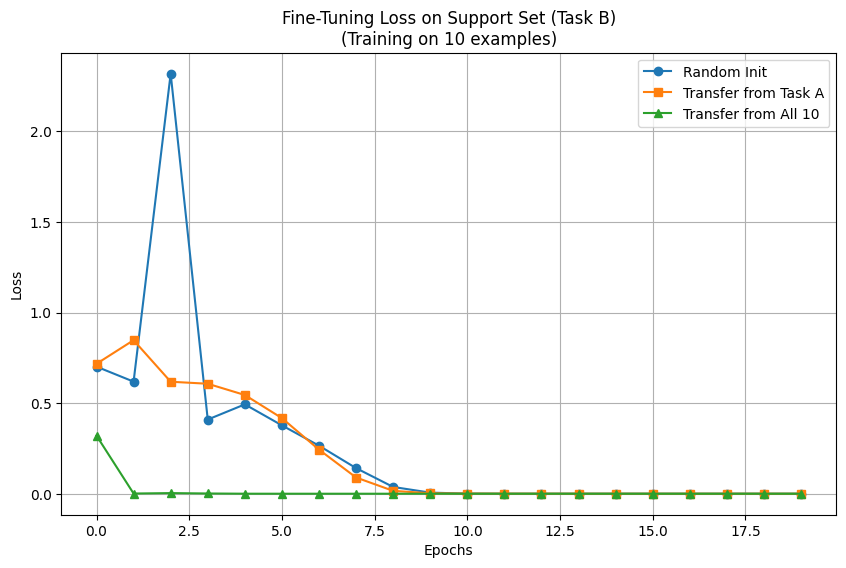

Method                    | Accuracy   | Precision  | Recall    
-----------------------------------------------------------------
Random Init               | 0.9500     | 1.0000    | 0.9000
Transfer (Task A)         | 0.9000     | 1.0000    | 0.8000
Transfer (All 10)         | 0.9500     | 1.0000    | 0.9000


In [13]:
#Analysis and Plots
# --- Evaluation Helper Function ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(model, data_list):
    model.eval()
    all_preds = []
    all_labels = []

    # Create loader for query data
    loader = DataLoader(data_list, batch_size=16)

    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())

    return {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds, zero_division=0),
        'Recall': recall_score(all_labels, all_preds, zero_division=0),
        'F1': f1_score(all_labels, all_preds, zero_division=0)
    }

# --- 1. Evaluate on Task B Query Set ---
results = {}
results['Random Init'] = evaluate(model_random, query_B)
results['Transfer (Task A)'] = evaluate(model_transfer_A, query_B)
results['Transfer (All 10)'] = evaluate(model_transfer_All, query_B)

# --- 2. Plotting Learning Curves ---
plt.figure(figsize=(10, 6))
plt.plot(loss_random, label='Random Init', marker='o')
plt.plot(loss_transfer_A, label='Transfer from Task A', marker='s')
plt.plot(loss_transfer_All, label='Transfer from All 10', marker='^')

plt.title(f"Fine-Tuning Loss on Support Set (Task B)\n(Training on {len(support_B)} examples)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Performance Table ---
print(f"{'Method':<25} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10}")
print("-" * 65)
for name, metrics in results.items():
    print(f"{name:<25} | {metrics['Accuracy']:.4f}     | {metrics['Precision']:.4f}    | {metrics['Recall']:.4f}")

Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



Answer 1: Strategy 3 Pre-train on All 10 Digits works best.A neural network acts as a "feature extractor" followed by a classifier.

Random Initialization Strategy 1 typically underperforms because 5-10 support images are insufficient to learn complex visual features edges, curves, loops from scratch without overfitting.

Transfer from Task A Strategy 2 is better but biased. It knows features for digits "0" and "1" like ovals and lines but may lack the specific features needed for "2" or "3" (like open curves).

Transfer from All 10 Strategy 3 provides the most robust feature extractor. Having seen all 10 digits during pre-training, the network's filters have already learned to recognize every possible shape needed to distinguish any number. Fine-tuning simply involves re-mapping these existing features to the new labels, rather than learning how to see from scratch.

Answer 2: Although the model has seen the digits 2 and 3 before, fine-tuning is necessary because of the Classifier Head.The pre-trained model had a 10 way output head.For the new task, we replaced this with a random 2 way binary head.This new binary head is initialized randomly. It does not know that Output 0 should correspond to the features of a 2.Finetuning primarily updates the weights of the new head to wire the correct existing features from the frozen backbone to the new output nodes. It essentially learns a mapping rule rather than learning new visual features.

Answer 3: Yes, it will work significantly better than random initialization, though likely not as well as Letter to Letter transfer.The early layers of a CNN learn universal visual primitives like Gabor filters edges, corners, gradients. An edge in the letter 'A' is mathematically identical to an edge in the digit '4'.Deeper layers detecting shapes like loops in 0, 8, 9 can be reused for letters with loops B, P, D.To make this work effectively, you should freeze the early convolutional layers to preserve universal feature detectors and only fine-tune the later layers and the head. This prevents the small support set from destroying the robust low-level filters (Catastrophic Forgetting).

Answer 4:Technically, we have not used a Meta-Learning Algorithm, but we are working within a Meta-Learning Problem Setting. We are testing Meta-Learning concepts (specifically Few-Shot Learning) by using the Support/Query set structure to evaluate how quickly a model can adapt to a new task with minimal data.The methods we used to solve this (Random Init, Pre-training) are standard Transfer Learning techniques. We did not use a Meta-Learning optimization algorithm  that explicitly trains the model how to learn. We simply pre-trained a model and hoped it would transfer well. MAML would take this a step further by explicitly optimizing the initial weights for adaptability.

Answer 5: Yes, we that only behind Model-Agnostic Meta-Learning (MAML).Imagine the loss landscape has a valley for optimal Digit weights and a different "valley" for optimal Letter weights. Standard Transfer Learning puts you deep into one valley, making it hard to climb out and reach the other.MAML attempts to find a set of initialization weights on the "ridge" between these valleys.While this initialization might not have high accuracy on digits or letters immediately (high initial loss), it is positioned such that a small gradient step in one direction falls into the Digit solution, and a small step in the other direction falls into the Letter solution. This optimizes the model for fast adaptation across dissimilar tasks.

# ALL THE BEST !